In [164]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

# Objectives
#### 1. Identify significant variables that contribute to customer churn
#### 2. Predict future chrun rate using the developed model

In [165]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [166]:
# Checking for missing data
data.isna().sum()
# Removing ID
data.drop("customerID", inplace = True, axis = 1)

In [167]:
# Checking Datatypes
data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [168]:
# data['gender'] = data['gender'].map({'Female': 1, 'Male': 0})
# data['Partner'] = data['Partner'].map({'Yes': 1, 'No': 0})

# data['Dependents'] = data['Dependents'].map({'Yes': 1, 'No': 0})
# data['PhoneService'] = data['PhoneService'].map({'Yes': 1, 'No': 0})
# data['MultipleLines'] = data['MultipleLines'].map({'Yes': 1, 'No': 0, 'No phone service':2})

# data['InternetService'] = data['InternetService'].map({'No':0,'Fiber optic': 1, 'DSL': 2})
# data['OnlineSecurity'] = data['OnlineSecurity'].map({'Yes':1,'No':0,'No internet service':2})
# data['OnlineBackup'] = data['OnlineBackup'].map({'Yes':1,'No':0,'No internet service':2})
# data['DeviceProtection'] = data['DeviceProtection'].map({'Yes':1,'No':0,'No internet service':2})

# data['TechSupport'] = data['TechSupport'].map({'Yes':1, 'No':0, 'No internet service':2})
# data['StreamingTV'] = data['StreamingTV'].map({'Yes':1,'No':0, 'No internet service':2})
# data['StreamingMovies'] = data['StreamingMovies'].map({'Yes':1,'No':0, 'No internet service':2})
# data['Contract'] = data['Contract'].map({'Month-to-month':0,'Two year':2,'One year':1})

# data['PaperlessBilling'] = data['PaperlessBilling'].map({'Yes': 1, 'No': 0}) 
# data['PaymentMethod'] = data['PaymentMethod'].map({'Electronic check': 1, 'Mailed check': 2, 'Bank transfer (automatic)': 3, 'Credit card (automatic)':4 }) 
# data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})
# data['TotalCharges'].replace(' ',0)
# data['TotalCharges'] = data['TotalCharges'].astype(float)

data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [169]:
from sklearn.preprocessing import LabelEncoder
for column in data:
    if data[column].dtype == np.number:
        continue
    data[column] = LabelEncoder().fit_transform(data[column])

C:\Users\User\AppData\Local\Temp\ipykernel_10316\2092214897.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if data[column].dtype == np.number:


In [170]:
print(data.dtypes)
data.head()

gender                int32
SeniorCitizen         int64
Partner               int32
Dependents            int32
tenure                int64
PhoneService          int32
MultipleLines         int32
InternetService       int32
OnlineSecurity        int32
OnlineBackup          int32
DeviceProtection      int32
TechSupport           int32
StreamingTV           int32
StreamingMovies       int32
Contract              int32
PaperlessBilling      int32
PaymentMethod         int32
MonthlyCharges      float64
TotalCharges          int32
Churn                 int32
dtype: object


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,2505,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1466,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,157,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1400,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,925,1


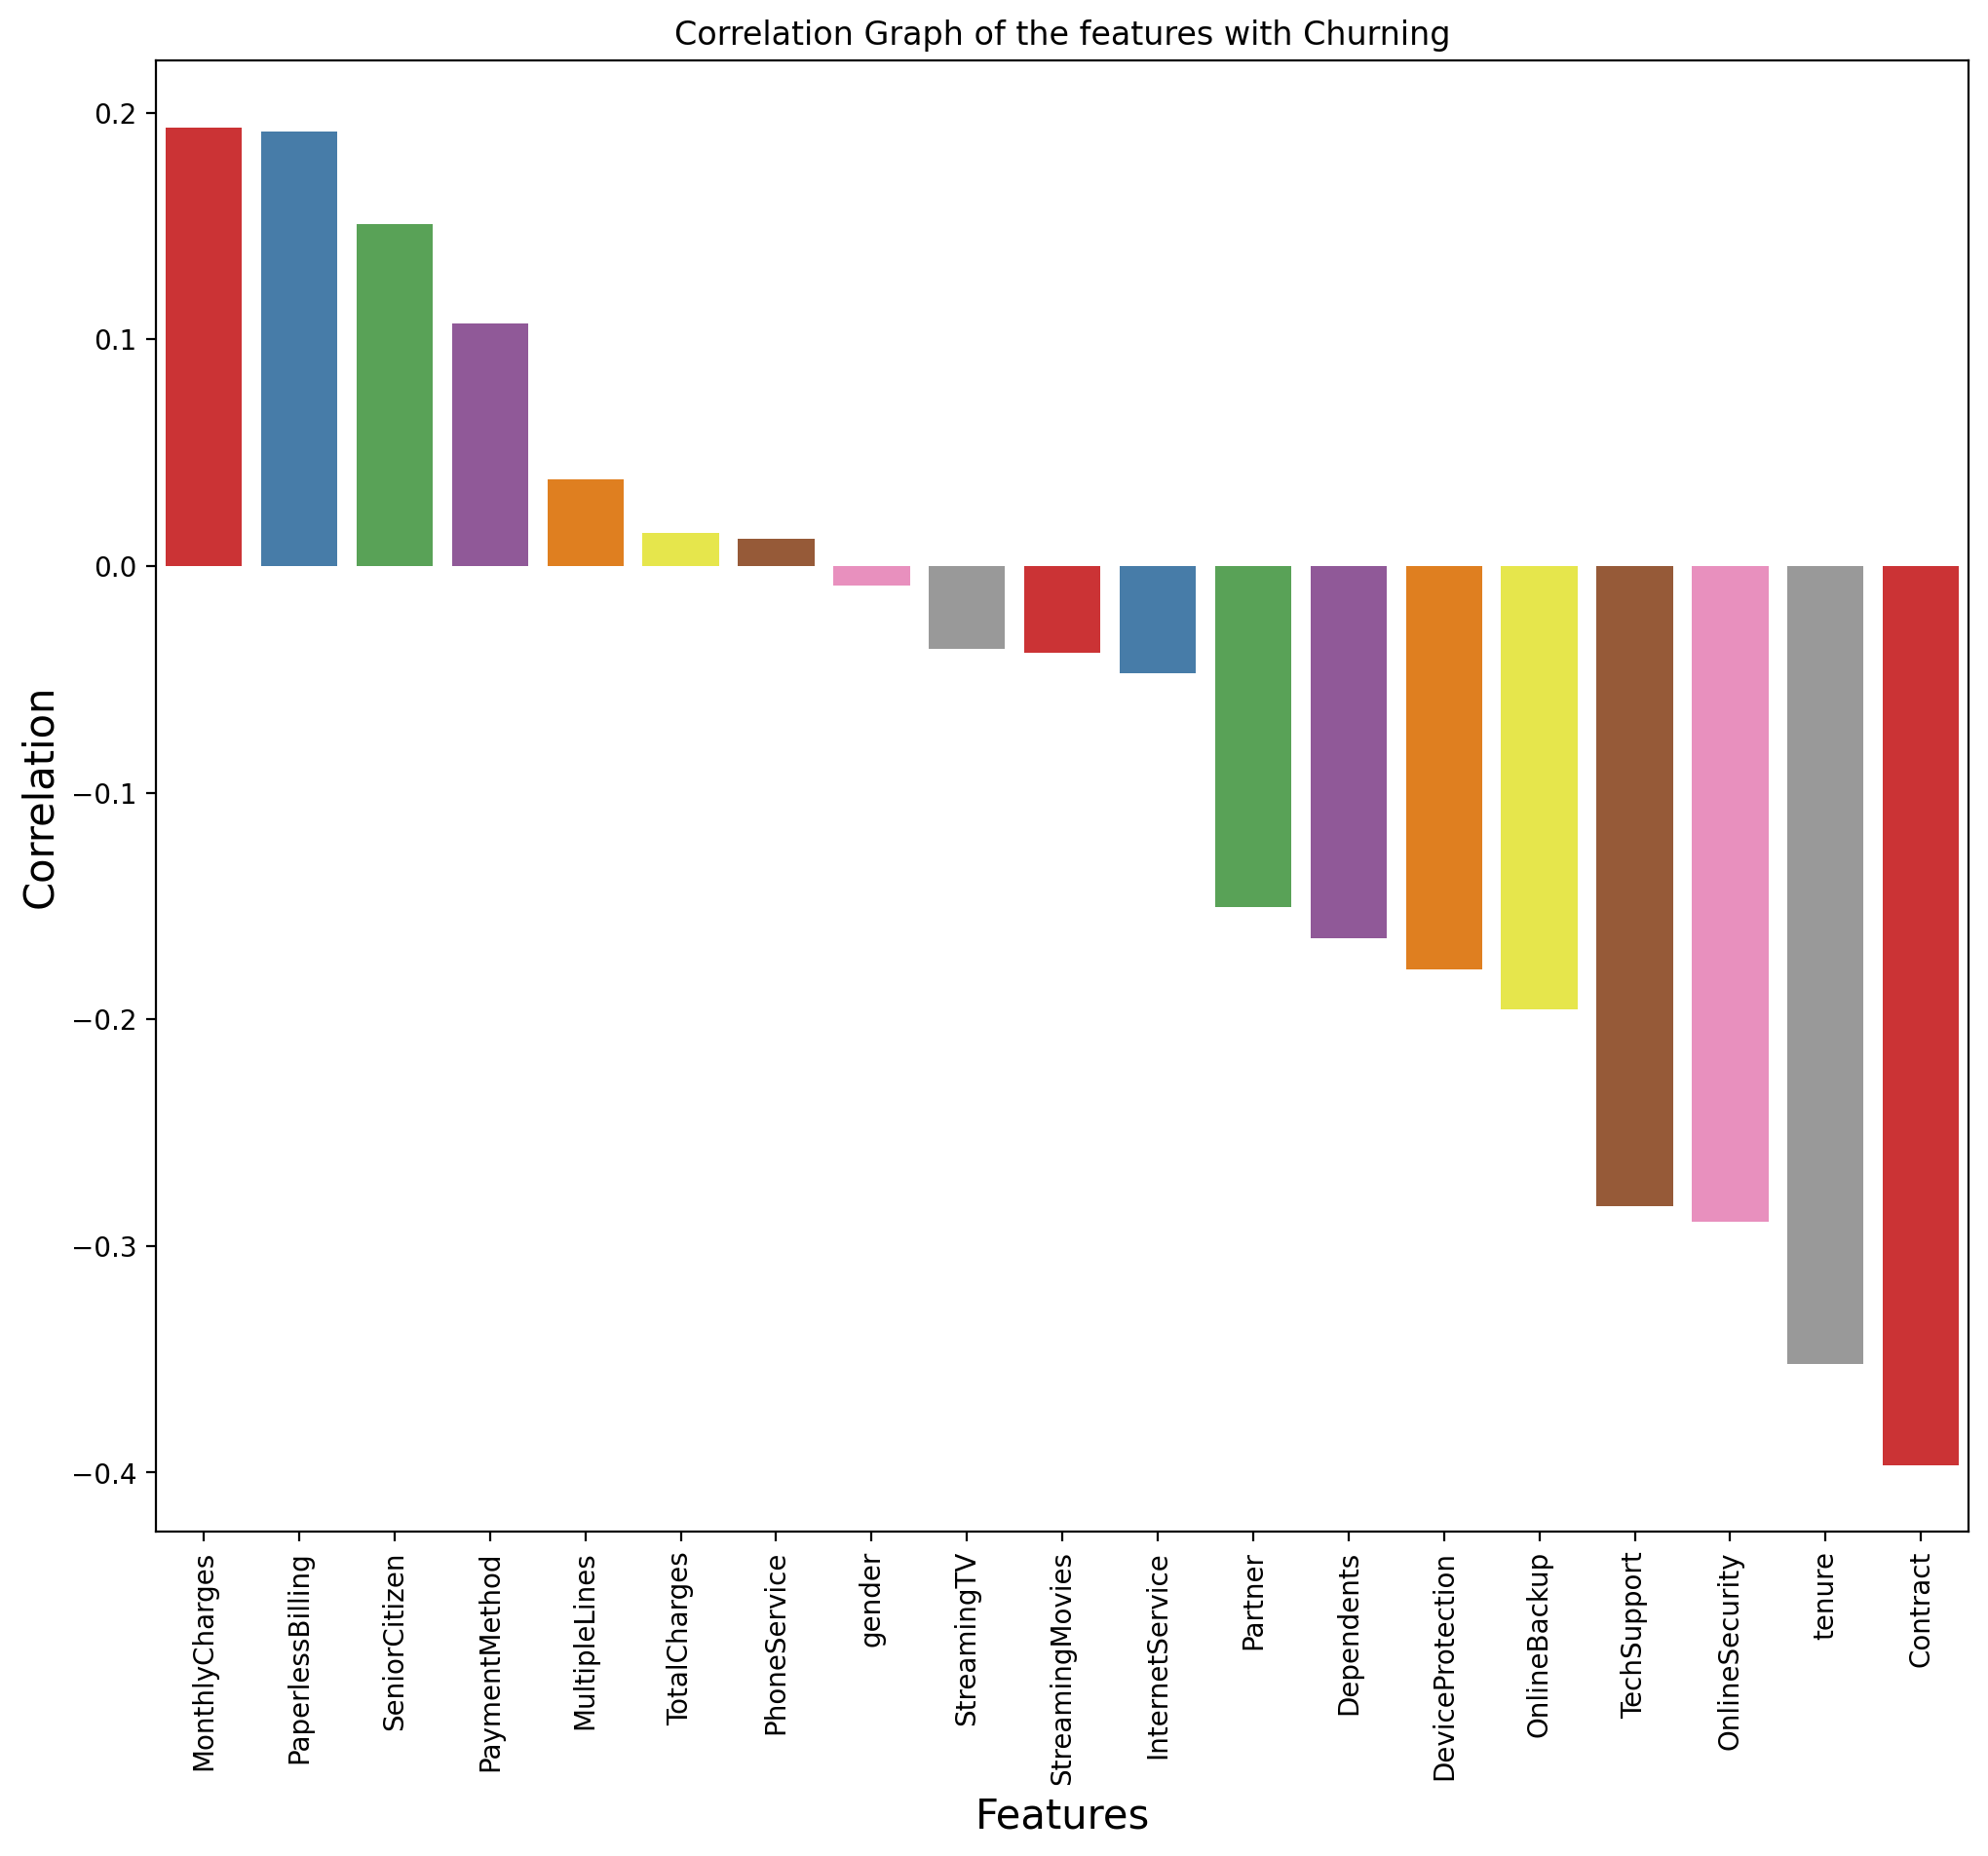

In [171]:
# We will make a barplot of the correlated features
values = data.corr()['Churn'].sort_values(ascending=False)[1:].values
index = data.corr()['Churn'].sort_values(ascending=False)[1:].index

# We will create a pallete also 
palette = 'Set1'

# Now we will create the plot
fig, ax = plt.subplots(figsize=(12, 10), dpi=200)
sns.barplot(x=index, y=values, palette=palette,ax=ax)
plt.xticks(rotation=90)
plt.title('Correlation Graph of the features with Churning')
plt.ylabel('Correlation', fontsize=15)
plt.xlabel('Features', fontsize=15)
plt.show()

In [172]:
X = data.copy()
X.drop('Churn',inplace=True, axis=1)
y = data['Churn']

In [173]:
# ###initialize Boruta
# forest = RandomForestRegressor(
#    n_jobs = -1, 
#    max_depth = 5
# )
# boruta = BorutaPy(
#    estimator = forest, 
#    n_estimators = 'auto',
#    max_iter = 300 # number of trials to perform
# )
# ### fit Boruta (it accepts np.array, not pd.DataFrame)
# boruta.fit(np.array(X), np.array(y))
# ### print results
# green_area = X.columns[boruta.support_].to_list()
# blue_area = X.columns[boruta.support_weak_].to_list()
# print('features in the green area:', green_area)
# print('features in the blue area:', blue_area)

In [174]:
# getting the correlation for features in green area
churn_series = data['Churn']
corr_data = []
for f in data.columns:
    corr_data.append([f,np.corrcoef(data[f],churn_series)[0][1]])
corr_data.sort(key = lambda x : x[1])
corr_data

[['Contract', -0.39671262920984235],
 ['tenure', -0.3522286701130779],
 ['OnlineSecurity', -0.28930899612232425],
 ['TechSupport', -0.28249160820465163],
 ['OnlineBackup', -0.19552501409217646],
 ['DeviceProtection', -0.17813386106687648],
 ['Dependents', -0.16422140157972498],
 ['Partner', -0.15044754495917664],
 ['InternetService', -0.047291387683142366],
 ['StreamingMovies', -0.038491628519887355],
 ['StreamingTV', -0.03658099337318671],
 ['gender', -0.008612095078997864],
 ['PhoneService', 0.01194198002900294],
 ['TotalCharges', 0.014478977600651788],
 ['MultipleLines', 0.0380368856061871],
 ['PaymentMethod', 0.1070620058734036],
 ['SeniorCitizen', 0.1508893281764732],
 ['PaperlessBilling', 0.19182533166646806],
 ['MonthlyCharges', 0.19335642223784705],
 ['Churn', 1.0]]

In [182]:
# Only consider important features
# get data above certain value



data = data[map(corr_data[:4],lambda x : x[0])] 

AttributeError: 'list' object has no attribute 'map'

In [176]:
# Standardisation
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [177]:
# Provides train/test indices to split data in train/test sets.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [178]:
# We create the model.
model = sklearn.linear_model.LogisticRegression()
# We train the model.
model.fit(X_train, y_train)

LogisticRegression()

In [179]:
predictions = model.predict(X_test)
predictions

array([0, 0, 0, ..., 0, 0, 1])

In [180]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1061
           1       0.62      0.57      0.59       348

    accuracy                           0.81      1409
   macro avg       0.74      0.73      0.73      1409
weighted avg       0.80      0.81      0.80      1409



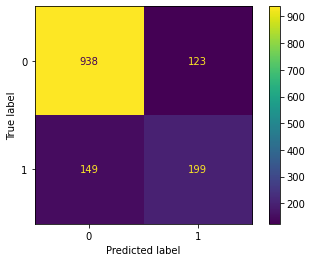

In [181]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
# Confusion Matrix 
cm = confusion_matrix(y_test, predictions)
display = ConfusionMatrixDisplay(cm)
display.plot()
plt.show()